I needed to get the coastline from a list of countries. I followed the methodology described here. In the end, I didn't have to intersect the physical boundaries of the country with the coastlines data as described in the following link for the purpose I had in mind. But this would not be much complicated to accomplish.

https://gist.github.com/pelson/336ca11b877d9e1e4aff

In [1]:
import numpy as np
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
%matplotlib inline

# get the country map list
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural', name=shapename)

#coastline_shp = shpreader.natural_earth(resolution='50m', category='physical', name='coastline')
#coastline = list(shpreader.Reader(coastline_shp).geometries())

Given the filename in ``countries_shp`` let's use cartopy's shapereader to conveniently access the shapefile's records and associated geometries (noting that there is one record per country).

We then extract from ``countries_shp``, the ones with are interrested in.

In [2]:
list_countries = ['South Africa', 'Mozambique', 'United Republic of Tanzania', 'Kenya', 
                  'Somalia', 'Madagascar', 'France', 'Mauritius']

#for record in shpreader.Reader(states_shp).records():
#    print(record.attributes['ADMIN'])

countries = [record for record in shpreader.Reader(countries_shp).records()
          if record.attributes['ADMIN'] in list_countries]

Note that ``countries_shp`` is a list of "records" containing a (or more) ``geometry`` attributes.

To match the order of the ``countries`` we built with our ``list_countries``, it as to be in a reverse sort.

In [3]:
list_countries = sorted(list_countries, reverse=True)

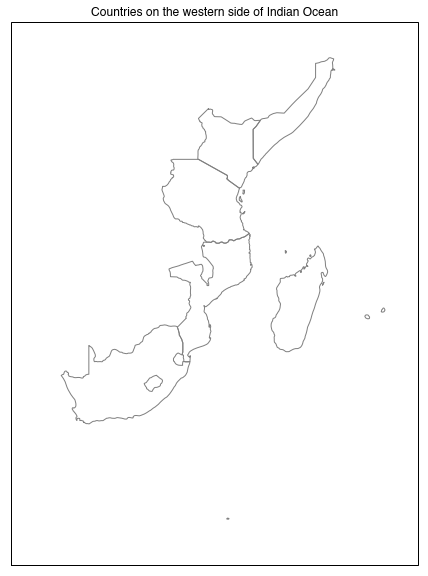

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

for i, country in enumerate(countries):
    ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                  facecolor='none', edgecolor='gray', linewidth=1)

ax.set_extent([10, 62, -50, 15])
plt.title('Countries on the western side of Indian Ocean')
plt.show()

On first sight we are almost done, but if we remove the axis extent, we can see that some countries contains geometry that we are not interrested in. 

For example, we only want to keep Reunion island and not France and all the other associated territories. Same thing for South Africa, we will only be keep the main region.

At the same time, I will store the different arrays to later be able to intersect in with the Indian Ocean gridded domain from another project.

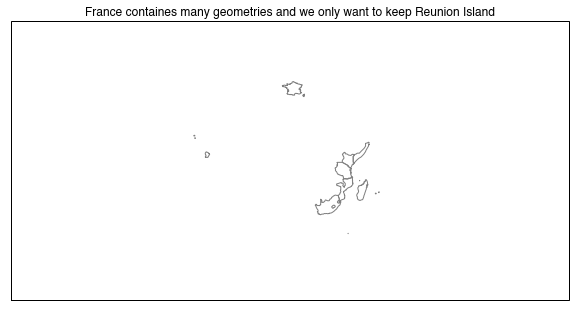

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

for i, country in enumerate(countries):
    ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                  facecolor='none', edgecolor='gray', linewidth=1)
plt.title('France containes many geometries and we only want to keep Reunion Island')
plt.show()

In [6]:
for i, country in enumerate(countries):
    print(list_countries[i] + ' has ' + str(len(country.geometry)) + ' geometries.')

United Republic of Tanzania has 4 geometries.
South Africa has 2 geometries.
Somalia has 1 geometries.
Mozambique has 1 geometries.
Mauritius has 1 geometries.
Madagascar has 3 geometries.
Kenya has 2 geometries.
France has 10 geometries.


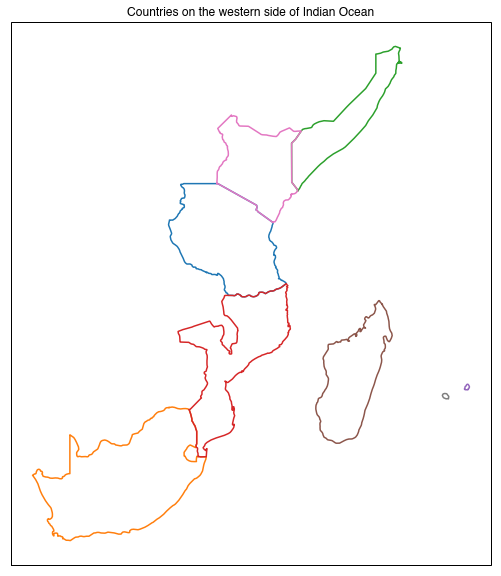

In [7]:
# for each of the countries with more then 1 geometry we chose which one we want to keep all (-1)
# or one particular geometry I haven't found a better way then trying each of them individually
index_geometries = [2,0,0,0,0,0,1,4]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

for i, country in enumerate(countries):
    if index_geometries[i] == -1:
        for geo in country.geometry:
            coords = geo.exterior.coords.xy
            plt.plot(coords[0], coords[1])
    else:
        coords = country.geometry[index_geometries[i]].exterior.coords.xy
        plt.plot(coords[0], coords[1])

#ax.set_extent([15, 62, -35, 13])
plt.title('Countries on the western side of Indian Ocean')
plt.show()

## Exporting the different arrays
Ok, so we've now done a reasonable investigation of the processing needed to compute the desired geometries, we now want to write those geometries back out to a shapefile. To do this, we are going to want to use Fiona.

In [8]:
from datetime import datetime
from pathlib import Path
from netCDF4 import Dataset

def save_array(filename, coords):
    # delete if file exist
    if Path(filename).is_file(): os.remove(filename)
    
    # transform into numpy arrays
    lon = np.array(coords[0])
    lat = np.array(coords[1])

    # file create
    # basic description and variable dimensions
    f = Dataset(filename, 'w', format='NETCDF4')
    f.history = "Created " + datetime.today().strftime("%d/%m/%y")
    f.description = "Border of selected countries or territories."
    f.createDimension('npoints', len(lon))

    # create variables in netCDF file
    # vectors
    lon_ = f.createVariable('lon', lon.dtype, 'npoints')
    lat_ = f.createVariable('lat', lat.dtype, 'npoints')
    lon_[:] = lon
    lat_[:] = lat
    lon_.units = 'degrees'
    lon_.units = 'degrees'
    f.close()

In [9]:
import os
for i, country in enumerate(countries):
    coords = country.geometry[index_geometries[i]].exterior.coords.xy
    save_array(list_countries[i] + '.nc', coords)

Let's confirm that the netCDF files contains the information we were after by plotting it.

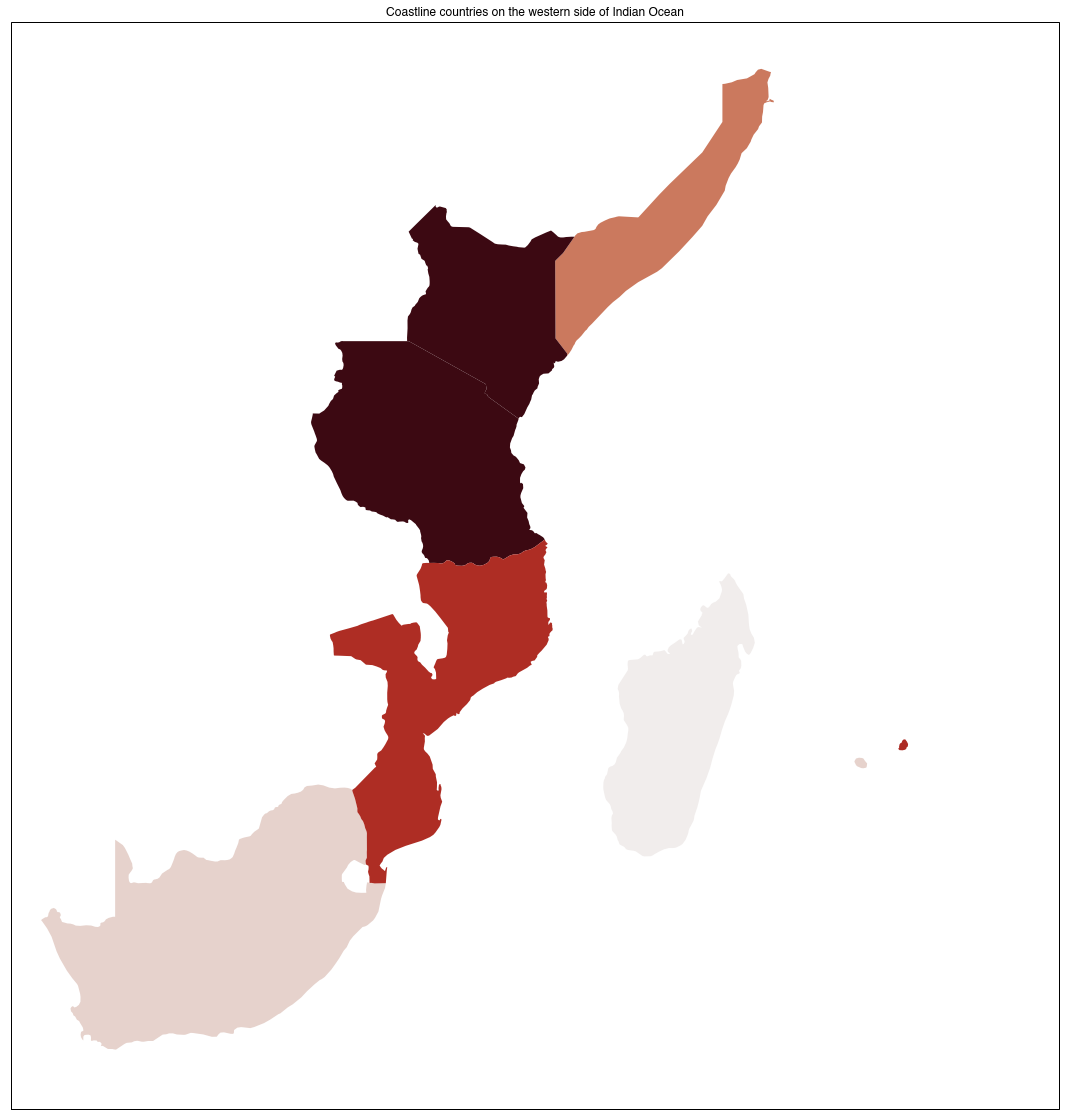

In [10]:
import h5netcdf
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import cmocean

plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())

patch = []
patch_ins = []
for country in list_countries:
    datafile = country + '.nc'
    with h5netcdf.File(os.path.expanduser(datafile), 'r') as f:
        lon = f['lon'][...]
        lat = f['lat'][...]
    c = Polygon(np.column_stack([lon,lat]))
    patch.append(c)

p = PatchCollection(patch, cmap=cmocean.cm.amp, alpha=1.0)
prob = np.random.rand(len(list_countries)-2)
p.set_array(prob / np.max(prob))
ax.add_collection(p)
ax.set_extent([15, 65, -35, 13])
ax.set_title('Coastline countries on the western side of Indian Ocean')
plt.show()